In [172]:
# Modèle théorique d'estimation des émissions sur le périphérique parisien
# Inspiré de la décomposition de Bigo (2020)

# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

In [173]:
# --- Paramètres par défaut ---
def default_params():
    return {
        "distance_moyenne_km": 35,
        "demande_passagers_km": 35_000_000, # 35 * 100 000 voyageurs
        "part_voitures_thermiques": 0.7,
        "part_voitures_diesel": 0.2,
        "part_voitures_elec": 0.1,
        "conso_l_100km_essence_70": 7.0,
        "conso_l_100km_essence_50": 6.5,
        "conso_l_100km_diesel_70": 5.5,
        "conso_l_100km_diesel_50": 5.0,
        "conso_kWh_100km_elec_70": 17.0,
        "conso_kWh_100km_elec_50": 15.5,
        "emission_CO2_l_essence": 2.3,
        "emission_CO2_l_diesel": 2.6,
        "emission_CO2_kWh": 0.012,
        "emission_NOx_g_km_essence": 0.25,
        "emission_NOx_g_km_diesel": 0.6,
        "emission_NOx_g_km_elec": 0.01,
        "emission_PM10_g_km_essence": 0.01,
        "emission_PM10_g_km_diesel": 0.05,
        "emission_PM10_g_km_elec": 0.005,
        "taux_remplissage_actuel": 1.2,
        "taux_remplissage_covoit": 1.8,
        "part_covoiturage": 0.4,
        "duree_jours": 365,
        "part_temps_pointe": 0.31,
        "seuil_congestion": 100000,
        "seuil_max_congestion": 200000
    }

In [174]:
# --- Fonction de congestion non linéaire ---
def facteur_congestion(nb_vehicules, seuil, seuil_max, nb_voies):
    """
    Calcule un facteur de surconsommation lié à la congestion du trafic.

    Paramètres :
    - nb_vehicules : nombre de véhicules estimés sur le tronçon
    - seuil : seuil à partir duquel la congestion commence à impacter la consommation
    - seuil_max : valeur au-delà de laquelle la congestion est très élevée

    Retourne :
    - Un facteur multiplicatif de consommation (ex. 1.0 = fluide, >1.0 = congestion)
    """
    
    # Densité = véhicules / nombre de voies
    densite = nb_vehicules / nb_voies

    if densite <= seuil:
        return 1.0
    elif densite <= seuil_max:
        return 1.0 + 0.1 * (densite - seuil) / (seuil_max - seuil)
    else:
        return 1.1 + 0.1 * (densite - seuil_max) / seuil_max

In [175]:
# --- Fonction d'estimation des émissions ---
def calcul_emissions(params, vitesse_reduite=False, part_temps=1.0, voie_covoit_activee=False):
    """
    Estime les émissions de CO2, NOx et PM10 selon les paramètres donnés.

    - Si la voie de covoiturage est activée et qu'on est aux heures de pointe,
      on distingue deux groupes de véhicules (prioritaires et classiques).
    - Sinon, tous les véhicules sont traités de manière homogène.

    Paramètres :
    - params : dictionnaire contenant tous les paramètres du modèle
    - vitesse_reduite : booléen, si la vitesse est réduite (50 km/h au lieu de 70)
    - part_temps : part du temps journalier considéré (ex : 0.31 pour les heures de pointe)
    - voie_covoit_activee : booléen, True si la voie réservée est active
    """

    # --- Paramètres de base ---
    d = params["distance_moyenne_km"]                   # distance moyenne par véhicule
    D = params["demande_passagers_km"]                  # demande totale (en pass.km)
    jours = params["duree_jours"]                       # nombre de jours considérés

    # Calcul automatique de la part de personnes voyageant seules (non-covoiturées)
    part_solo = 1 - params["part_covoiturage"]

    # Centré sur les personnes (80% voyagent seuls)
    r = 1 / (part_solo / 1.0 + params["part_covoiturage"] / params["taux_remplissage_covoit"]) #combien de personnes en moyenne transp. par 1 véhicule basé sur comportement des gens

    # Nombre total de véhicules requis
    n = D / (r * d)
    print(f"\n>>> Nombre de véhicules ajusté : {n:.0f}")

    # --- Cas spécial : voie de covoiturage active aux heures de pointe ---

    if voie_covoit_activee and part_temps == params["part_temps_pointe"]:

        print(">>> Mode spécial : voie covoiturage activée aux heures de pointe")


        # Calcule la part de véhicules qui peuvent utiliser la voie réservée
        # Inclure une base minimale de véhicules autorisés à utiliser la voie (ex: bus, VTC, secours)
        base_vehicules_autorises = 0.1  # 5%
        part_prioritaire = base_vehicules_autorises + params["part_covoiturage"]
        part_prioritaire = min(part_prioritaire, 1.0)
        part_classique = 1 - part_prioritaire

        n_prioritaire = n * part_prioritaire
        n_classique = n * part_classique

        # congestion dynamique selon la part de la voie utilisée
        congestion_p = facteur_congestion(n_prioritaire, params["seuil_congestion"], params["seuil_max_congestion"], nb_voies=1)
        congestion_c = facteur_congestion(n_classique, params["seuil_congestion"], params["seuil_max_congestion"], nb_voies=3)

        result = {"CO2": 0, "NOx": 0, "PM10": 0}

        for n_groupe, congestion in [
            (n_prioritaire, congestion_p),
            (n_classique, congestion_c)
        ]:
            for type_v, part_motor in [
                ("essence", params["part_voitures_thermiques"]),
                ("diesel", params["part_voitures_diesel"]),
                ("elec", params["part_voitures_elec"])
            ]:
                if type_v == "essence":
                    conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
                    CO2e = params["emission_CO2_l_essence"]
                    NOx = params["emission_NOx_g_km_essence"]
                    PM = params["emission_PM10_g_km_essence"]
                elif type_v == "diesel":
                    conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
                    CO2e = params["emission_CO2_l_diesel"]
                    NOx = params["emission_NOx_g_km_diesel"]
                    PM = params["emission_PM10_g_km_diesel"]
                else:
                    conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
                    CO2e = params["emission_CO2_kWh"]
                    NOx = params["emission_NOx_g_km_elec"]
                    PM = params["emission_PM10_g_km_elec"]

                km_total = part_motor * n_groupe * d * part_temps
                consommation_totale = km_total * (conso / 100) * congestion
                result["CO2"] += consommation_totale * CO2e / 1000 * jours
                result["NOx"] += km_total * NOx / 1_000_000 * jours
                result["PM10"] += km_total * PM / 1_000_000 * jours

    # --- Cas classique : tous les véhicules traités ensemble ---
    else:
        congestion = facteur_congestion(n, params["seuil_congestion"], params["seuil_max_congestion"], nb_voies=4)

        result = {"CO2": 0, "NOx": 0, "PM10": 0}

        for type_v, part in [
            ("essence", params["part_voitures_thermiques"]),
            ("diesel", params["part_voitures_diesel"]),
            ("elec", params["part_voitures_elec"])
        ]:
            if type_v == "essence":
                conso = params["conso_l_100km_essence_50"] if vitesse_reduite else params["conso_l_100km_essence_70"]
                CO2e = params["emission_CO2_l_essence"]
                NOx = params["emission_NOx_g_km_essence"]
                PM = params["emission_PM10_g_km_essence"]
            elif type_v == "diesel":
                conso = params["conso_l_100km_diesel_50"] if vitesse_reduite else params["conso_l_100km_diesel_70"]
                CO2e = params["emission_CO2_l_diesel"]
                NOx = params["emission_NOx_g_km_diesel"]
                PM = params["emission_PM10_g_km_diesel"]
            else:
                conso = params["conso_kWh_100km_elec_50"] if vitesse_reduite else params["conso_kWh_100km_elec_70"]
                CO2e = params["emission_CO2_kWh"]
                NOx = params["emission_NOx_g_km_elec"]
                PM = params["emission_PM10_g_km_elec"]

            km_total = part * n * d * part_temps
            consommation_totale = km_total * (conso / 100) * congestion
            result["CO2"] += consommation_totale * CO2e / 1000 * jours
            result["NOx"] += km_total * NOx / 1_000_000 * jours
            result["PM10"] += km_total * PM / 1_000_000 * jours

    return result

In [176]:
# --- Fusion pointe / hors-pointe ---
def emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False):
    """
    Calcule les émissions totales en combinant les périodes de pointe et hors-pointe.

    Paramètres :
    - params : dictionnaire contenant tous les paramètres du modèle
    - vitesse_reduite : booléen, True si la vitesse est réduite à 50 km/h
    - voie_covoit_activee : booléen, True si la voie de covoiturage est activée pendant les heures de pointe

    Retour :
    - Dictionnaire avec les émissions annuelles totales de CO2, NOx et PM10 (en tonnes)
    """

    # --- Répartition du temps ---
    part_pointe = params["part_temps_pointe"]  # part du temps journalier en heure de pointe (ex. 0.31)
    part_off = 1 - part_pointe                 # part du temps en heure creuse (hors-pointe)

    # --- Ajustement de la surconsommation aux heures de pointe ---
    # (ancien système — plus utilisé ici, mais laissé par sécurité)
    surconso_pointe = params["surconso_congestion_pointe"]
    if voie_covoit_activee:
        # Si la voie covoiturage est active, on réduit un peu la surconsommation estimée
        surconso_pointe = min(1.05, surconso_pointe - 0.05)

    # --- Calcul des émissions pour les heures de pointe ---
    res_pointe = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_pointe,
        voie_covoit_activee=voie_covoit_activee  # on active la logique des 2 groupes si demandé
    )

    # --- Calcul des émissions pour les heures hors-pointe ---
    res_off = calcul_emissions(
        params,
        vitesse_reduite=vitesse_reduite,
        part_temps=part_off,
        voie_covoit_activee=False  # la voie covoiturage est inactive hors-pointe
    )

    # --- Somme des émissions totales sur l’année ---
    total = {
        k: res_pointe[k] + res_off[k] for k in res_pointe
    }
    return total


In [177]:
# --- Affichage ---
def afficher_resultats(params):
    scenarios = {
        "A. 70 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=False, voie_covoit_activee=False),
        "B. 50 km/h sans voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=False),
        "C. 50 km/h avec voie covoiturage": emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    }

    for nom, valeurs in scenarios.items():
        print(f"\n{nom} :")
        for polluant, val in valeurs.items():
            print(f"  {polluant} : {val:.2f} t/an")

    labels = list(scenarios.keys())
    CO2_vals = [scenarios[k]["CO2"] for k in labels]
    NOx_vals = [scenarios[k]["NOx"] for k in labels]
    PM10_vals = [scenarios[k]["PM10"] for k in labels]

    x = np.arange(len(labels))
    width = 0.25

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # CO2
    axes[0].bar(labels, CO2_vals, color='green')
    axes[0].set_title("Émissions de CO₂")
    axes[0].set_ylabel("t/an")
    axes[0].tick_params(axis='x', rotation=20)

    # NOx
    axes[1].bar(labels, NOx_vals, color='orange')
    axes[1].set_title("Émissions de NOx")
    axes[1].tick_params(axis='x', rotation=20)

    # PM10
    axes[2].bar(labels, PM10_vals, color='gray')
    axes[2].set_title("Émissions de PM10")
    axes[2].tick_params(axis='x', rotation=20)

    plt.tight_layout()
    plt.show()

In [178]:
# --- Interface interactive ---
@interact(
    distance_moyenne_km=FloatSlider(min=10, max=50, step=1, value=35, description="km/jour"),
    part_covoiturage=FloatSlider(min=0.0, max=0.5, step=0.01, value=0.2, description="% covoiturage"),
    surconso_congestion_pointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.1, description="Surconso pointe"),
    surconso_congestion_offpointe=FloatSlider(min=1.0, max=1.2, step=0.01, value=1.0, description="Surconso hors-pointe"),
    seuil_congestion=FloatSlider(min=50000, max=200000, step=5000, value=100000, description="Seuil congestion"),
    seuil_max_congestion=FloatSlider(min=100000, max=300000, step=5000, value=200000, description="Seuil max congestion")
)
def simulation_interactive(distance_moyenne_km, part_covoiturage,
                           surconso_congestion_pointe, surconso_congestion_offpointe,
                           seuil_congestion, seuil_max_congestion):
    params = default_params()
    params.update({
    "distance_moyenne_km": distance_moyenne_km,
    "part_covoiturage": part_covoiturage,
    "surconso_congestion_pointe": surconso_congestion_pointe,
    "surconso_congestion_offpointe": surconso_congestion_offpointe,
    "seuil_congestion": seuil_congestion,
    "seuil_max_congestion": seuil_max_congestion
})
    afficher_resultats(params)

interactive(children=(FloatSlider(value=35.0, description='km/jour', max=50.0, min=10.0, step=1.0), FloatSlide…


>>> Nombre de véhicules ajusté : 1000000
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 1000000

>>> Nombre de véhicules ajusté : 995556
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 995556

>>> Nombre de véhicules ajusté : 991111
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 991111

>>> Nombre de véhicules ajusté : 986667
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 986667

>>> Nombre de véhicules ajusté : 982222
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 982222

>>> Nombre de véhicules ajusté : 977778
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombre de véhicules ajusté : 977778

>>> Nombre de véhicules ajusté : 973333
>>> Mode spécial : voie covoiturage activée aux heures de pointe

>>> Nombr

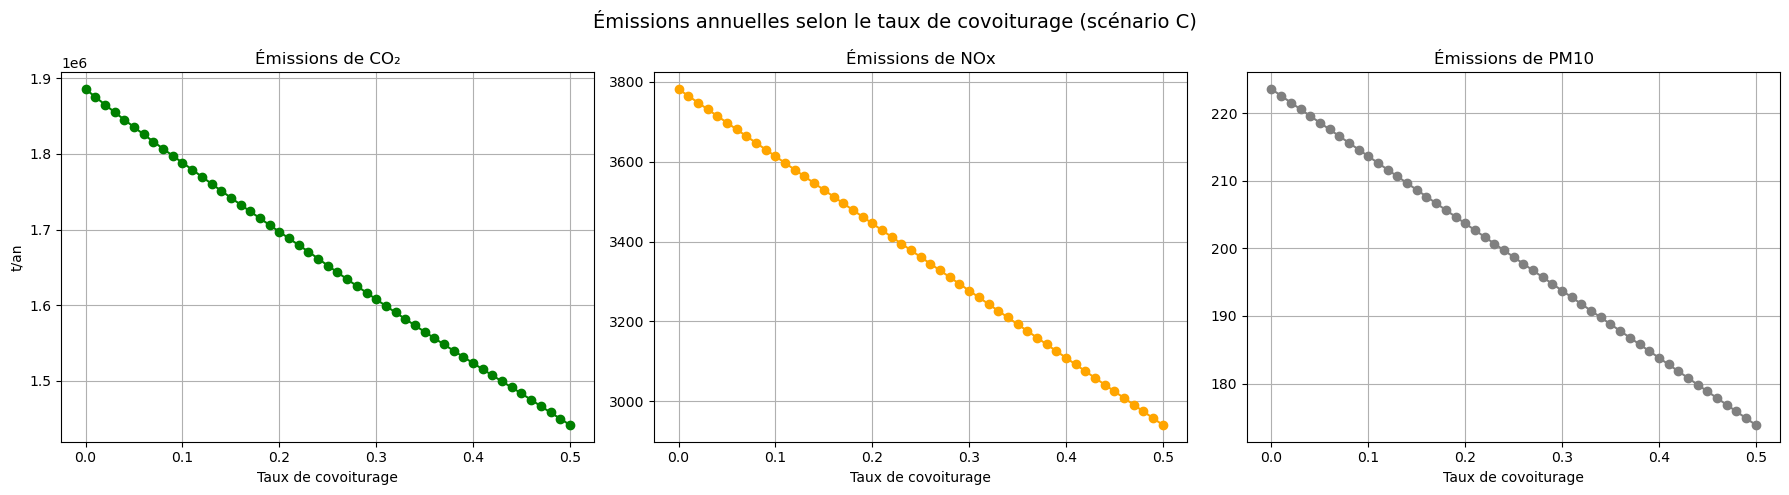

In [179]:
# --- Visualisation des émissions selon le taux de covoiturage ---
covoit_range = np.linspace(0, 0.5, 51)
CO2_vals = []
NOx_vals = []
PM10_vals = []

for cov in covoit_range:
    params = default_params()
    params.update({
        "part_covoiturage": cov,
        "surconso_congestion_pointe": 1.1,
        "surconso_congestion_offpointe": 1.0,
        "seuil_congestion": 100000,
        "seuil_max_congestion": 200000
    })
    emissions = emissions_horaires_combinees(params, vitesse_reduite=True, voie_covoit_activee=True)
    CO2_vals.append(emissions["CO2"])
    NOx_vals.append(emissions["NOx"])
    PM10_vals.append(emissions["PM10"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(covoit_range, CO2_vals, marker='o', color='green')
axes[0].set_title("Émissions de CO₂")
axes[0].set_xlabel("Taux de covoiturage")
axes[0].set_ylabel("t/an")
axes[0].grid(True)

axes[1].plot(covoit_range, NOx_vals, marker='o', color='orange')
axes[1].set_title("Émissions de NOx")
axes[1].set_xlabel("Taux de covoiturage")
axes[1].grid(True)

axes[2].plot(covoit_range, PM10_vals, marker='o', color='gray')
axes[2].set_title("Émissions de PM10")
axes[2].set_xlabel("Taux de covoiturage")
axes[2].grid(True)

plt.suptitle("Émissions annuelles selon le taux de covoiturage (scénario C)", fontsize=14)
plt.tight_layout()
plt.show()